<img src="https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/agods/nyp_ago_logo.png" width='400'/>

# Fraud Detection 

In this exercise, we will build a financial fraud detection model. The model is a binary classifier that classifies a transaction as non-fraud (negative case) and fraud (positive case).

There is a lack of publicly available datasets on financial services and specially in the emerging mobile money transactions domain. We will be using a sythetic dataset called PaySim. PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. You can find out more how the data is generate from the [paper](http://www.msc-les.org/proceedings/emss/2016/EMSS2016_249.pdf).

Here are the description of the different columns of the PaySim dataset: 

|Field|Description|
|-----|-----|
|step|Maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).|
|type|CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER|
|amount|Amount of the transaction in local currency|
|nameOrig|Customer who started the transaction|
|oldbalanceOrg|Initial balance before the transaction|
|newbalanceOrig|New balance after the transaction|
|nameDest|Customer who is the recipient of the transaction|
|oldbalanceDest|Initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants)|
|newbalanceDest|New balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants)|
|isFlaggedFraud|The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction|
|isFraud|This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system|


## Import Packages

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import lightgbm as lgb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Import the Data 

In [3]:
df = pd.read_csv('Fraud.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


For consistency, let's correct spelling of original column headers.

In [5]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Let's check for any missing values. It turns out there are no obvious missing values but, as we will see below, value 0 may be used as a proxy if no data is available (e.g. those in the newBalanaceOrig, newBalanceDest, etc)

In [6]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Exploratory Data Analysis

In this section, we will do some data-wrangling to gain more insights into the dataset.

**Exercise** 

Let's find out how many different types of transactions first. How many types of transactions are there?

In [7]:
## complete the code

print(df.type.value_counts())
print(df.type.unique())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


#### Which types of transactions are fraudulent? 

We would like to find out which type of transactions are most fraudulent? We find that of the various types of transactions, fraud occurs only in two of them:
'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. 

In [8]:
df.loc[df.isFraud == 1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

Let's find the percentage of fraudulent transactions that belong to TRANSFER type. 

In [9]:
num_fraudulent_xfer = len(df.loc[ (df.isFraud == 1) & (df.type == 'TRANSFER')])
percentage_fraudulent_xfer = num_fraudulent_xfer / len(df.loc[df.isFraud == 1])
print(f'number of fraudulent TRANSFER = {num_fraudulent_xfer}')
print(f'percentage of fraudulent TRANSFER = {percentage_fraudulent_xfer}')

number of fraudulent TRANSFER = 4097
percentage of fraudulent TRANSFER = 0.4988432972117375


**Exercise**

1. Find out how many fraudulent CASH_OUT?  
2. Find out what is the percentage of fraudulent transactions is of CASH_OUT type.
3. What do you observe? 

<details><summary>Click here for solution</summary>
<br/>
    
```python 
num_fraudulent_cash_out = len(df.loc[ (df.isFraud == 1) & (df.type == 'CASH_OUT')])
percentage_fraudulent_cash_out = num_fraudulent_cash_out / len(df.loc[df.type == 'CASH_OUT'])
print(f'number of fraudulent CASH_OUT = {num_fraudulent_cash_out}')
print(f'percentage of fraudulent CASH_OUT = {percentage_fraudulent_cash_out}')
```
<br/>
We observe that the number of fraudulent TRANSFERs is almost equals the number of fraudulent CASH_OUTs These observations appear to bear out the description provided on Kaggle that the modus operandi of fraudulent transactions in  this dataset is committed by first transferring out funds to another account which subsequently cashes it out.


In [10]:
## complete the code 

num_fraudulent_cash_out = len(df.loc[ (df.isFraud == 1) & (df.type == 'CASH_OUT')])
percentage_fraudulent_cash_out = num_fraudulent_cash_out / len(df.loc[df.isFraud == 1])
print(f'number of fraudulent CASH_OUT = {num_fraudulent_cash_out}')
print(f'percentage of fraudulent CASH_OUT = {percentage_fraudulent_cash_out}')

number of fraudulent CASH_OUT = 4116
percentage of fraudulent CASH_OUT = 0.5011567027882625


#### Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?

From the data description, the modus operandi for committing fraud involves first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT.

In [11]:
dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print('\nOf all fraudulent transactions, destinations for TRANSFERS that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False


Of all fraudulent transactions, destinations for TRANSFERS that are also originators for CASH_OUTs? False


However, our analysis above showed there are no  such common accounts among fraudulent transactions. Thus, the data is not imprinted with the expected modus-operandi. We can therefore drop the nameDest and nameOrig from the features used for modelling later.

#### Are the destination accounts with zero balances before and after non-zero amount is transacted normal?  

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. 

Let's find out the how many of these transactions, of type TRANSFER/CASH_OUT,  are actually fraudulent. 

In [12]:
dfFraudTransferCashOut = df.loc[(df.isFraud == 1) & ((df.type == 'TRANSFER') | (df.type == 'CASH_OUT'))]
dfNonFraudTransferCashOut = df.loc[(df.isFraud == 0) & ((df.type == 'TRANSFER') | (df.type == 'CASH_OUT'))]

print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(dfFraudTransferCashOut.loc[(dfFraudTransferCashOut.oldBalanceDest == 0) & \
(dfFraudTransferCashOut.newBalanceDest == 0) & (dfFraudTransferCashOut.amount != 0)]) / (1.0 * len(dfFraudTransferCashOut))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072


**Exercise** 

Now find out how many of these transactions (of type TRANSFER/CASH_OUT) are genuine (non-fraudulent) transaction. 

<details><summary>Click here for solution</summary>
<br/>

```python 
print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(dfNonFraudTransferCashOut.loc[(dfNonFraudTransferCashOut.oldBalanceDest == 0) & \
(dfNonFraudTransferCashOut.newBalanceDest == 0) & (dfNonFraudTransferCashOut.amount != 0 )]) / (1.0 * len(dfNonFraudTransferCashOut))))
```
<br/>
</details>

In [13]:
## Complete the code 

print("The fraction of genuine transactions with 'oldBalanceDest' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}".\
format(len(dfNonFraudTransferCashOut.loc[(dfNonFraudTransferCashOut.oldBalanceDest == 0) & \
(dfNonFraudTransferCashOut.newBalanceDest == 0) & (dfNonFraudTransferCashOut.amount != 0 )]) / (1.0 * len(dfNonFraudTransferCashOut))))


The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%). This shows that a 0 in the oldBalanceDest and newBalanceDest is a strong indicator of fraud.

In [14]:
print("The fraction of fraudulent transactions with 'oldBalanceOrig' = 'newBalanceOrig' = 0 although the transacted 'amount' is non-zero is: {}".
      format(len(dfFraudTransferCashOut.loc[(dfFraudTransferCashOut.oldBalanceOrig == 0) & 
                                            (dfFraudTransferCashOut.newBalanceOrig == 0) & 
                                            (dfFraudTransferCashOut.amount != 0)]) / (1.0 * len(dfFraudTransferCashOut))))

print("The fraction of genuine transactions with 'oldBalanceOrig' = newBalanceOrig' = 0 although the transacted 'amount' is non-zero is: {}".
      format(len(dfNonFraudTransferCashOut.loc[(dfNonFraudTransferCashOut.oldBalanceOrig == 0) & 
                                               (dfNonFraudTransferCashOut.newBalanceOrig == 0) & 
                                               (dfNonFraudTransferCashOut.amount != 0 )]) / (1.0 * len(dfNonFraudTransferCashOut))))

The fraction of fraudulent transactions with 'oldBalanceOrig' = 'newBalanceOrig' = 0 although the transacted 'amount' is non-zero is: 0.0030439547059539756
The fraction of genuine transactions with 'oldBalanceOrig' = newBalanceOrig' = 0 although the transacted 'amount' is non-zero is: 0.4737321319703598


### Feature-engineering

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we create 2 new features (columns) recording errors in the  originating and destination accounts for each transaction.

In [15]:
df['errorBalanceOrig'] = df.newBalanceOrig + df.amount - df.oldBalanceOrig
df['errorBalanceDest'] = df.oldBalanceDest + df.amount - df.newBalanceDest

### Correlation of features to the target label

Let's find out the correlation of each of our numerical features with the target label, for all TRANSFER/CASH_OUT transactions.

In [16]:
dfTransferCashOut = df[ (df.type == 'TRANSFER') | (df.type == 'CASH_OUT') ] 

In [17]:
corr_matrix = dfTransferCashOut.corr()
# corr_matrix['median_house_value'].sort_values(ascending=False)

C:\Users\markk\AppData\Local\Temp\ipykernel_20940\2914629405.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dfTransferCashOut.corr()


In [18]:
corr_matrix['isFraud'].abs().sort_values(ascending=False)

isFraud             1.000000
oldBalanceOrig      0.347582
amount              0.070660
errorBalanceDest    0.069935
newBalanceOrig      0.063557
step                0.048671
isFlaggedFraud      0.044072
errorBalanceOrig    0.017149
oldBalanceDest      0.014960
newBalanceDest      0.008978
Name: isFraud, dtype: float64

## Create Train/Test Set 

From the exploratory data analysis (EDA), we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we create a train/test set only from those transaction. Also, we will drop the nameOrig and nameDest, as our EDA shows that they are not relevant in predicting if a transaction is fraud or not.  We also need to convert the TRANSFER and CASHOUT to a numeric value instead.

**Exercise**

1. Create a dataframe that consists of TRANSFER/CASH_OUT transactions only
2. Drop the following features 'nameOrig', 'nameDest' 
3. Map the type TRANSFER to numeric value 0, and CASH_OUT to numeric value 1
4. create features (X), and labels (y) 
5. create train/test split of 80:20 ratio

In [20]:
## Complete the code 

# 1. Create a dataframe that consists of TRANSFER/CASH_OUT transactions only

dfTransferCashOut = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

# 2. Drop the following features 'nameOrig', 'nameDest'
dfTransferCashOut = dfTransferCashOut.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# 3. Map the type TRANSFER to numeric value 0, and CASH_OUT to numeric value 1
dfTransferCashOut['type'] = dfTransferCashOut['type'].apply(lambda x: 0 if x == 'TRANSFER' else 1)

# 4. create features (X) and labels (y) 
y = dfTransferCashOut['isFraud'] 
X = dfTransferCashOut.drop('isFraud', axis=1)

# 5. Create train/test split of 80:20 ratio 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 49)

In [21]:
X_train.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
4579783,328,1,54906.59,0.0,0.0,2448022.43,2502929.02,54906.59,0.000000e+00
5567764,393,1,402233.07,10070.0,0.0,103726.00,505959.07,392163.07,0.000000e+00
71064,9,1,414121.45,333684.6,0.0,0.00,414121.45,80436.85,0.000000e+00
1917013,166,1,568308.48,0.0,0.0,5033926.56,5602235.04,568308.48,-9.313226e-10
6138893,544,1,188285.60,0.0,0.0,1172663.35,1360948.95,188285.60,2.328306e-10


## Modeling 

We can see from below, the data is highly imbalanced. 

In [22]:
y.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

As the data is highly imbalanced, we will use the Area under Precision/Recall Curve (Average Precision) as metrics to measure the performance of the classifier.

### Linear Models

Let's train a Logistic Regressor to classify the fraud.

In [23]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [24]:
test_probs = lr_clf.predict_proba(X_test)
print('AUPRC for test set = {}'.format(average_precision_score(y_test, test_probs[:, 1])))

AUPRC for test set = 0.41919288984514796


In [25]:
train_probs = lr_clf.predict_proba(X_train)
print('AUPRC for train set = {}'.format(average_precision_score(y_train, train_probs[:, 1])))

AUPRC for train set = 0.43466570867358273


In [26]:
test_preds = lr_clf.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.47      0.40      0.43      1643

    accuracy                           1.00    554082
   macro avg       0.73      0.70      0.72    554082
weighted avg       1.00      1.00      1.00    554082



The performance is not great. Our recall/precison for fraud class is rather disappointing.  Let's apply higheer weightage to the minority class and try again. 

In [27]:
lr_clf = LogisticRegression(class_weight='balanced')
lr_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [28]:
train_scores = lr_clf.decision_function(X_train)
print('AUPRC for train set = {}'.format(average_precision_score(y_train, train_scores)))
test_scores = lr_clf.decision_function(X_test)
print('AUPRC for test set = {}'.format(average_precision_score(y_test, test_scores)))

AUPRC for train set = 0.5251836180349532
AUPRC for test set = 0.5194448888734761


In [29]:
test_preds = lr_clf.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93    552439
           1       0.02      0.97      0.04      1643

    accuracy                           0.88    554082
   macro avg       0.51      0.92      0.49    554082
weighted avg       1.00      0.88      0.93    554082



**Exercise**

What do you observe about the precision/recall of the fraud class? 

<details><summary>Click here for answer</summary>
    
It seems that by placing more weights on 'fraud' class, we have managed to improve the recall rate for 'Fraud' but also increase the false positive (lower precision). 

### Oversampling 

It is difficult for our model to learn from a highly skewed dataset such as this, as there are simply too few fraud samples (minority class) compared to non-fraud (majority class). We can use oversampling technique to create more samples for minority class to make it a more balanced dataset. SMOTE (and it's variants are one such technique). 

Note that we should only perform oversampling on the train split only. 

In [30]:
#over_sample = SMOTE(sampling_strategy='auto')
over_sample = BorderlineSMOTE(sampling_strategy='auto')
X_train_oversampled,y_train_oversampled = over_sample.fit_resample(X_train,y_train)
print(y_train_oversampled.value_counts()) #resampled

0    2209757
1    2209757
Name: isFraud, dtype: int64


In [31]:
lr_clf_oversampled = LogisticRegression()
lr_clf_oversampled.fit(X_train_oversampled, y_train_oversampled)

LogisticRegression()

### Evaluation of Model Performance 

As mentioned before, for a skew dataset, accuracy is not a good metrics to use.  Let's see what is our accuracy score first:

In [32]:
from sklearn.metrics import accuracy_score

test_preds = lr_clf_oversampled.predict(X_test)
accuracy_score(y_test, test_preds)

0.9391371674228725

The accuracy looks very good. But this is misleading. We can find better insights by looking at the performance of each class (positive/negative) with classification report.

In [33]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    552439
           1       0.05      0.98      0.09      1643

    accuracy                           0.94    554082
   macro avg       0.52      0.96      0.53    554082
weighted avg       1.00      0.94      0.97    554082



#### Area under Precision Recall Curve (Average Precision)

Let's calculate the Area under Precision Recall curve. 

In [34]:
train_probs = lr_clf_oversampled.predict_proba(X_train)
print('AUPRC for train set = {}'.format(average_precision_score(y_train, train_probs[:,1])))
test_probs = lr_clf_oversampled.predict_proba(X_test)
print('AUPRC for test set = {}'.format(average_precision_score(y_test, test_probs[:,1])))

AUPRC for train set = 0.7130898210566263
AUPRC for test set = 0.7107675749342904


Our AUPRC seems to improve with oversampling. However, if we look at the classification report for the positive and negative class, we see that our precision with positive class (i.e. the fraud case) is extremely low, i.e. a lot of false positives.  The `predict()` function uses a default threshold of 0.5 (probability) to decide if something is a positive or negative class. We can adjust this threshold to trade-off a bit of recall with precision, as in the following "Precision Recall Trade-off". 

#### Precision Recall Trade-off 

Let's plot the precision recall curve for visualization.  

In [35]:
precisions, recalls, thresholds = precision_recall_curve(y_test, test_probs[:,1])

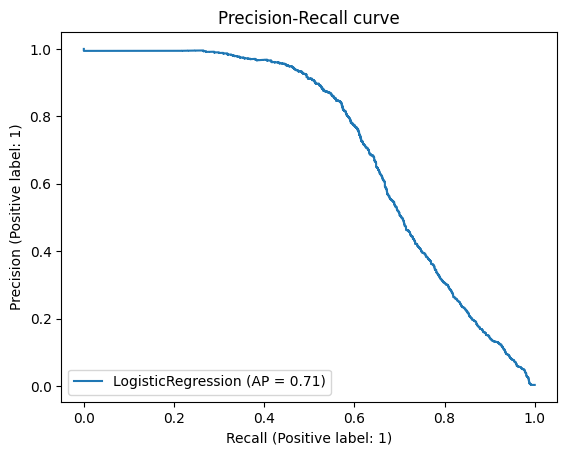

In [36]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, test_probs[:,1], name="LogisticRegression"
)
_ = display.ax_.set_title("Precision-Recall curve")

Assuming we want to get a higher precision and we are willing to trade-off for a lower recall, e.g. 0.65. 

In [37]:
threshold_65_recall = thresholds[np.argmin(recalls >= 0.65)]
threshold_65_recall

0.9923411416703614

Note that the threshold is now at more than 0.99, i.e. we will only classify a case as "fraud" if the classifier is 99% sure that this is fraud. Now we can use this threshold for deciding if a prediction is positive (fraud) or negative (non-fraud) by checking if it is above or below this threshold.

In [38]:
y_test_pred_65 = (test_probs[:,1] >= threshold_65_recall)

In [39]:
print(classification_report(y_test, y_test_pred_65))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.65      0.65      0.65      1643

    accuracy                           1.00    554082
   macro avg       0.82      0.82      0.82    554082
weighted avg       1.00      1.00      1.00    554082



From the classification report, you can see that we achieve a higher precision of 0.58 if we are willing to lower our recall rate to 0.65. 

**Exercise** 

Assuming you want to have a higher recall rate of 0.75 instead of 0.65.  What is the expected precision for positive class? 
Write code to print the classification report based on this new criteria. 

In [40]:
## Complete the code 

threshold_75_recall = thresholds[np.argmin(recalls >= 0.75)]
threshold_75_recall
y_test_pred_75 = (test_probs[:,1] >= threshold_75_recall)
print(classification_report(y_test, y_test_pred_75))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.40      0.75      0.52      1643

    accuracy                           1.00    554082
   macro avg       0.70      0.87      0.76    554082
weighted avg       1.00      1.00      1.00    554082



### Non-linear Model

It seems that our linear model underfits quite badly with the data. Let's try a more complex ensemble model with boosting algorithms. In this case we will use a very fast boosting algorithm called lightGBM (you can try other boosting algorithm such as XGBoost)

Note: We did not cover this algorithm in the lecture. but we are using it here for comparison only. To learn more about lightGBM, you can refer to the [lightGBM website](https://github.com/microsoft/LightGBM) 

In [41]:
lgbm_clf = lgb.LGBMClassifier(num_leaves=30, learning_rate=0.05, n_estimators=30) 
lgbm_clf.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 6570, number of negative: 2209757
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 2216327, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002964 -> initscore=-5.818124
[LightGBM] [Info] Start training from score -5.818124


LGBMClassifier(learning_rate=0.05, n_estimators=30, num_leaves=30)

In [42]:
train_probs = lgbm_clf.predict_proba(X_train)
print('AUPRC for train set = {}'.format(average_precision_score(y_train, train_probs[:, 1])))
test_probs = lgbm_clf.predict_proba(X_test)
print('AUPRC for test set = {}'.format(average_precision_score(y_test, test_probs[:, 1])))

AUPRC for train set = 0.9985082112641652
AUPRC for test set = 0.996215013270626


In [43]:
test_preds = lgbm_clf.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       1.00      0.99      1.00      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



We can see that we achieve an almost perfect classifier!  Normally boosting classifier is very effective in dealing with imbalanced dataset. 

The LightGBM also allows us to plot the importance of various features used in the model. The feature

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

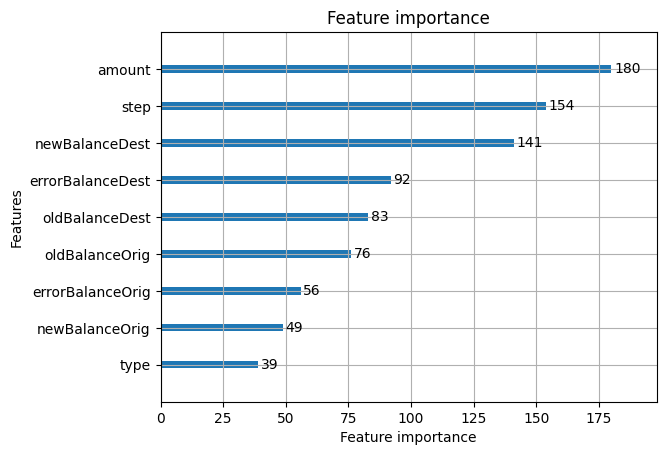

In [44]:
lgb.plot_importance(lgbm_clf)